In [38]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD 

# Importing and Visualizing Data
Data is downloaded to home directory. 

Using Kaggle instead

In [39]:
# !pip install kagglehub
# This one takes 3 minutes
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/mulugetah/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2


In [40]:
import numpy as np
import os
import pandas as pd

# Loading data into the memory is not efficient since it doesn't have enough memory for that much data
# Load filenames into dataframe instead

images = []

labels = []

label_count = 0

images_path = path + r"/images/Images/"

for label in os.listdir(images_path):
    label_path = images_path + label + "/"
    label_count += 1
    for file in os.listdir(label_path):
        images.append(label_path + file)
        labels.append(label.split('-')[1])

df = pd.DataFrame({"image_path" : images, "label": labels})

df = df[df['label'].isin(df['label'].unique()[:10])]


In [41]:
df.value_counts('label')


label
Maltese_dog            252
Afghan_hound           239
Shih                   214
papillon               196
Blenheim_spaniel       188
Japanese_spaniel       185
Rhodesian_ridgeback    172
toy_terrier            172
Chihuahua              152
Pekinese               149
Name: count, dtype: int64

In [42]:
df.shape

(1919, 2)

In [43]:
X_train, X_temp = train_test_split(df, test_size=0.2, stratify=df["label"], random_state = 42)

label_test_val = X_temp['label']

# 10%.   10%
X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (1535, 2)
The shape of test data (192, 2)
The shape of validation data (192, 2)


In [44]:
# parameters
image_size = 255 # Size of the image
image_channel = 3 # Colour scale (RGB)
bat_size = 1 # Number of files/images processed at once

In [45]:
# Applyingimage data gernerator to train and test data
datagen = ImageDataGenerator(
            validation_split=0.2,
            rescale=1./255, # to bring the image range from 0..255 to 0..1
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0, # randomly zoom image 
            width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=False,  # randomly flip images
            vertical_flip=False) # randomly flip images

train_generator = datagen.flow_from_dataframe(X_train,
                                                    x_col= 'image_path',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size),
                                                    class_mode="categorical",
                                                   )
val_generator = datagen.flow_from_dataframe(X_val, 
                                                 x_col= 'image_path',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False,
                                                 class_mode="categorical",
                                                )

test_generator = datagen.flow_from_dataframe(X_test, 
                                                  x_col= 'image_path',
                                                  y_col= 'label',
                                                  batch_size = bat_size,
                                                  target_size = (image_size,image_size),
                                                  shuffle=False,
                                                  class_mode="categorical",
                                                 )

Found 1535 validated image filenames belonging to 10 classes.
Found 192 validated image filenames belonging to 10 classes.
Found 192 validated image filenames belonging to 10 classes.


In [46]:
# use the data generator
num_classes = len(test_generator.class_indices)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
#Plots our figures
for i in range(1,5):
  plt.subplot(1, 4, i)
  batch = next(test_generator)
  image_ = batch[0][0]
  plt.imshow(image_)
plt.show()

# CNN
Everything after this is specific to Convolutional Nueral Networks but you can try to look at how it is set up.

In [56]:
from tensorflow.keras.applications import VGG16

# Load the VGG16 model
base_model = VGG16(
    weights = 'imagenet', 
    input_shape = (image_size, image_size, image_channel),
    include_top=False)

#freezing the base model
base_model.trainable = False


In [57]:
model = Sequential()

# Add maxpooling layers along with convolutional layers
# change activation funcitnos to leaky_relu
# add a dense layer after the flatten

model.add(base_model)

# Input Layer
model.add(Conv2D(32,(3,3),activation='leaky_relu',input_shape = (image_size,image_size,image_channel))) 

model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Conv2D(filters=64, kernel_size=2, activation='leaky_relu'))
model.add(Dropout(0.2))

# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Conv2D(filters=128 , kernel_size=2 , padding='same' , activation='leaky_relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.2))

# model.add(Conv2D(filters=256 , kernel_size=2 , padding='same' , activation='leaky_relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.2))

# Fully Connected layers 
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.05)))
model.add(Dropout(0.4))

# Output layer
model.add(Dense(num_classes,activation='softmax')) # Softmax for binary classification

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 5, 32)          147488    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 2, 2, 32)         0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 2, 2, 32)          0         
                                                                 
 flatten_4 (Flatten)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               33024     
                                                      

In [58]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [59]:
train_generator.target_size

(255, 255)

In [60]:
# Fine-tuning: Unfreeze some layers in ResNet
for layer in base_model.layers[-10:]:  # Unfreeze the last 10 layers
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [61]:
%%time
fitted = model.fit(train_generator,
                    validation_data = val_generator, 
                    epochs = 20,
                    steps_per_epoch = len(train_generator),
                    validation_steps = len(val_generator),
                   )

Epoch 1/20
1535/1535 [==============================] - 115s 74ms/step - loss: 10.4154 - accuracy: 0.1094 - val_loss: 9.6867 - val_accuracy: 0.1875
Epoch 2/20
1535/1535 [==============================] - 114s 75ms/step - loss: 9.1839 - accuracy: 0.1837 - val_loss: 8.6653 - val_accuracy: 0.2656
Epoch 3/20
1535/1535 [==============================] - 114s 74ms/step - loss: 8.2192 - accuracy: 0.2169 - val_loss: 7.7824 - val_accuracy: 0.3281
Epoch 4/20
1535/1535 [==============================] - 116s 75ms/step - loss: 7.3862 - accuracy: 0.2853 - val_loss: 7.0416 - val_accuracy: 0.3125
Epoch 5/20
1535/1535 [==============================] - 118s 77ms/step - loss: 6.7211 - accuracy: 0.3088 - val_loss: 6.4624 - val_accuracy: 0.4062
Epoch 6/20
1535/1535 [==============================] - 116s 76ms/step - loss: 6.1926 - accuracy: 0.3687 - val_loss: 5.9953 - val_accuracy: 0.4167
Epoch 7/20
1535/1535 [==============================] - 114s 74ms/step - loss: 5.7913 - accuracy: 0.3850 - val_loss: 

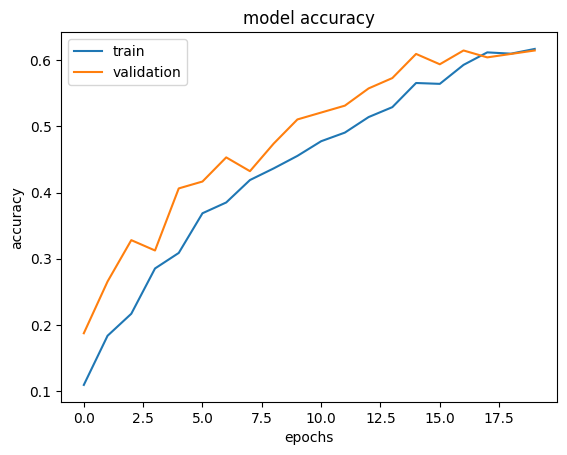

In [62]:
history = model.history

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [63]:

# Fine-tuning: Unfreeze some layers in ResNet
for layer in base_model.layers[-10:]:  # Unfreeze the last 10 layers
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    train_generator,
    validation_data = val_generator, 
    epochs = 20,
    steps_per_epoch = len(train_generator),
    validation_steps = len(val_generator),
)

Epoch 1/20
1535/1535 [==============================] - 115s 74ms/step - loss: 3.0162 - accuracy: 0.6482 - val_loss: 3.1381 - val_accuracy: 0.6094
Epoch 2/20
1535/1535 [==============================] - 113s 74ms/step - loss: 2.9196 - accuracy: 0.6586 - val_loss: 3.0330 - val_accuracy: 0.6302
Epoch 3/20
1535/1535 [==============================] - 114s 74ms/step - loss: 2.7996 - accuracy: 0.6749 - val_loss: 2.9545 - val_accuracy: 0.6250
Epoch 4/20
1535/1535 [==============================] - 114s 74ms/step - loss: 2.7158 - accuracy: 0.6678 - val_loss: 2.8666 - val_accuracy: 0.6302
Epoch 5/20
1535/1535 [==============================] - 114s 74ms/step - loss: 2.6360 - accuracy: 0.6736 - val_loss: 2.7910 - val_accuracy: 0.6094
Epoch 6/20
1535/1535 [==============================] - 114s 74ms/step - loss: 2.5446 - accuracy: 0.6886 - val_loss: 2.7102 - val_accuracy: 0.6354
Epoch 7/20
1535/1535 [==============================] - 114s 74ms/step - loss: 2.4319 - accuracy: 0.7225 - val_loss: 2

In [ ]:
history = model.history

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Using Classical Machine Learning
We will be using KMeans in order to try to classify the dog breeds. It probably won't perform well. 

As a start, we should pick the least well classified breeds and try to get the best scores we can before moving to DNN and CNNs. The image shows the best accuracies achieved in each breed. We will be trying to get the best in the bottom, say 5. 

![image](bar_graph_full.png)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image

image_size = 255
bat_size = 32

In [ ]:
def extract_images(generator):
    images = []
    labels = []
    for i, (image_batch, label_batch) in enumerate(generator):
        images.append(image_batch)
        labels.append(label_batch)
        if len(images) >= generator.samples:
            break
    images = np.vstack(images)
    labels = np.vstack(labels)
    return images, labels 

In [11]:
X_images, y_labels = extract_images(train_generator) 

X_flattened = X_images.reshape(X_images.shape[0], -1)

In [12]:
kmeans = KMeans(n_clusters=num_classes, random_state=42) 
kmeans.fit(X_flattened)

KMeans(n_clusters=56, random_state=42)

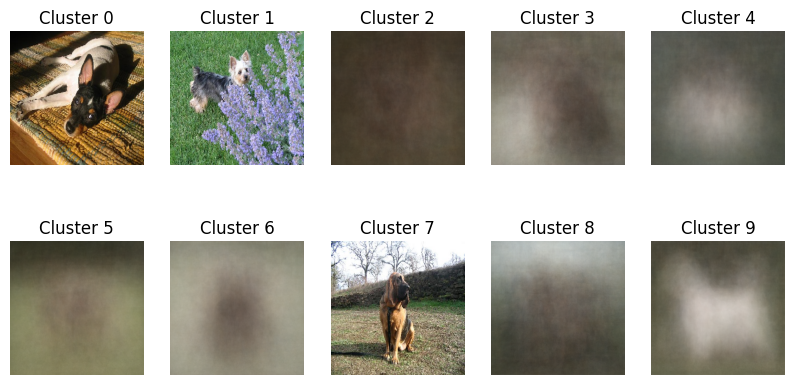

In [13]:
cluster_centers_reshaped = kmeans.cluster_centers_.reshape(num_classes, image_size, image_size, 3)
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(cluster_centers_reshaped[i])
    plt.title(f"Cluster {i}")
    plt.axis('off')
plt.show()

In [32]:
y_pred_train = kmeans.predict(X_flattened)
ari_train = adjusted_rand_score(np.argmax(y_labels, axis=1), y_pred_train)

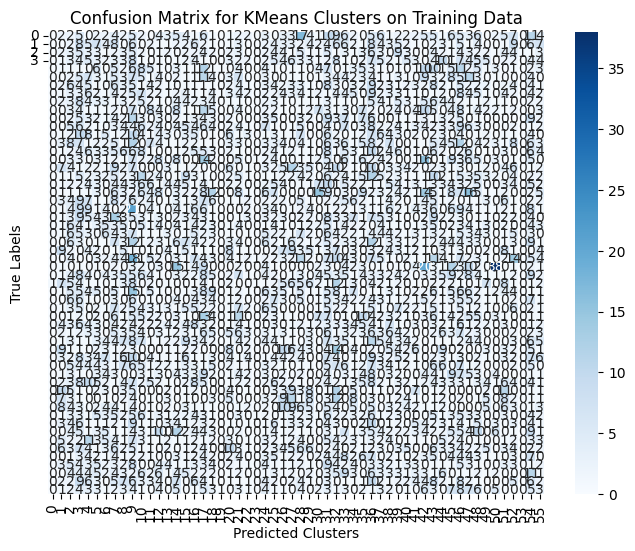

In [33]:
conf_matrix_train = confusion_matrix(np.argmax(y_labels, axis=1), y_pred_train)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(4))
plt.title('Confusion Matrix for KMeans Clusters on Training Data')
plt.xlabel('Predicted Clusters')
plt.ylabel('True Labels')
plt.show()

In [34]:
X_test_images, y_test_labels = extract_images(test_generator)

X_test_flattened = X_test_images.reshape(X_test_images.shape[0], -1)

y_pred_test = kmeans.predict(X_test_flattened)

ari_test = adjusted_rand_score(np.argmax(y_test_labels, axis=1), y_pred_test)

print(f"Adjusted Rand Index (ARI) on the test data: {ari_test:.4f}")

Adjusted Rand Index (ARI) on the test data: 0.0100


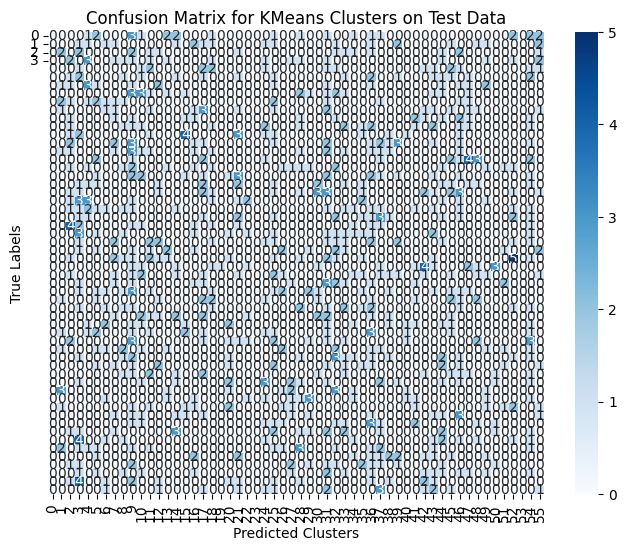

In [35]:
conf_matrix_test = confusion_matrix(np.argmax(y_test_labels, axis=1), y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(4))
plt.title('Confusion Matrix for KMeans Clusters on Test Data')
plt.xlabel('Predicted Clusters')
plt.ylabel('True Labels')
plt.show()


In [36]:
y_pred_test = kmeans.predict(X_test_flattened)

conf_matrix = confusion_matrix(np.argmax(y_test_labels, axis=1), y_pred_test)

cluster_to_label_mapping = np.argmax(conf_matrix, axis=1)


y_pred_mapped = np.array([None if cluster >= len(cluster_to_label_mapping) else cluster_to_label_mapping[cluster] for cluster in y_pred_test])

accuracy = np.mean(y_pred_mapped == np.argmax(y_test_labels, axis=1))

print(f"Accuracy of KMeans clustering: {accuracy:.4f}")

Accuracy of KMeans clustering: 0.0260
